In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor as xgbreg
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")


In [2]:
plt.rcParams["figure.dpi"] = 300


In [3]:
df = pd.read_csv('data/PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


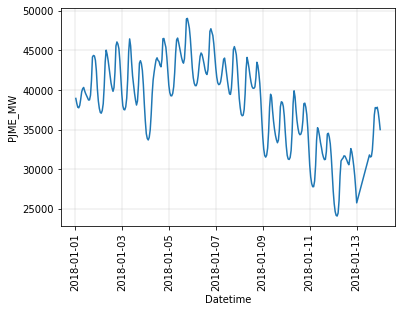

In [4]:
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df.tail(300), x='Datetime', y='PJME_MW')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

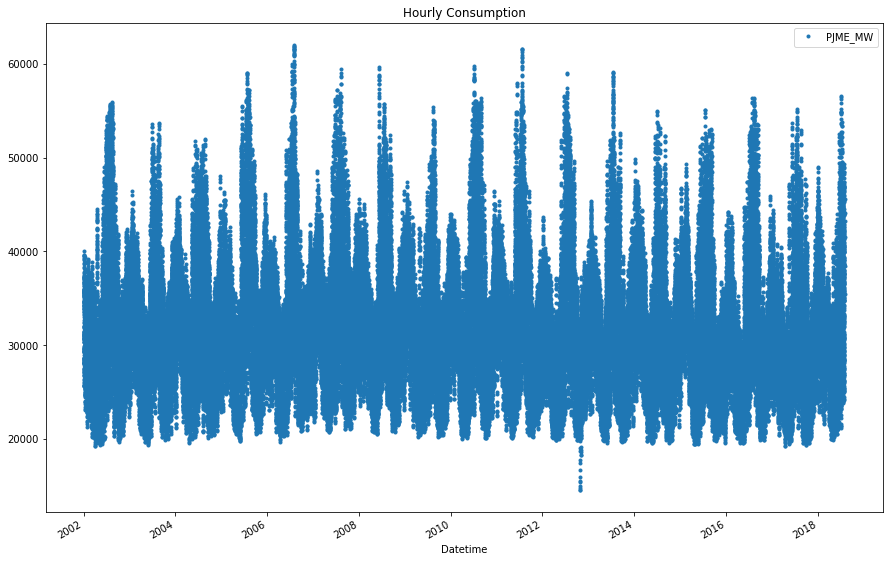

In [5]:
df.plot(style='.', figsize=(15,10), title = "Hourly Consumption")
plt.show()

In [6]:
data_split = '06-01-2015'

In [7]:
train_data = df.loc[df.index < data_split]
test_data = df.loc[df.index >= data_split]

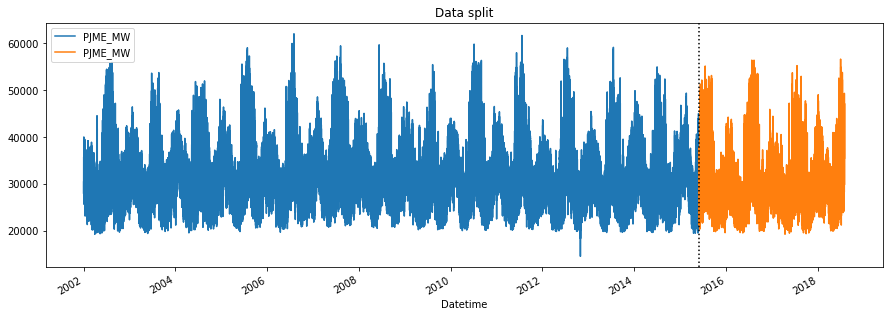

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label='Train Data', title="Data split")
test_data.plot(ax=ax, label='Test Data')
ax.axvline(data_split, color='black', ls='dotted')
plt.show()


<AxesSubplot:xlabel='Datetime'>

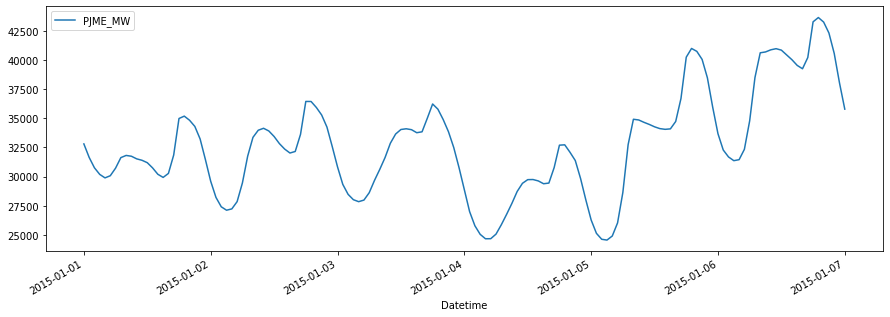

In [9]:
df.loc[(df.index  >= '01.01.2015') & (df.index <= '01.07.2015')].plot(figsize =(15,5))

In [10]:
def create_features(df):
    df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [11]:
df = create_features(df)

In [12]:
df.head()


,PJME_MW,hour,dayofweek,month,year,dayofyear
Datetime,,,,,,
2002-12-31 01:00:00,26498.0,1,1,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,12,2002,365


In [13]:
def show_distribution(feature):
    fig, ax = plt.subplots(figsize = (15, 5))
    sns.boxenplot(data=df, x=feature, y='PJME_MW')
    ax.set_title(f'MW by {feature}')
    plt.show()

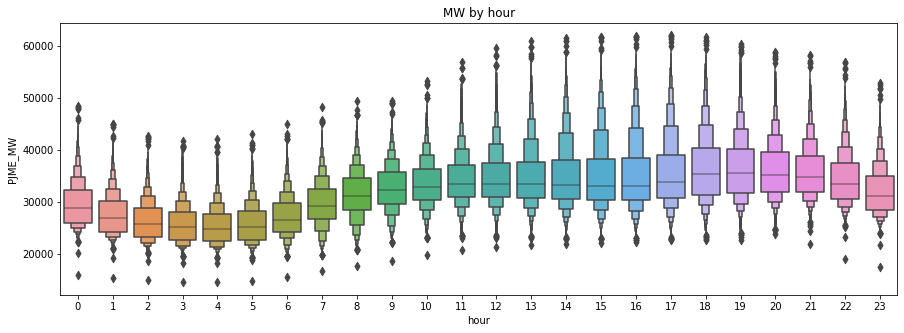

In [14]:
#hourly

show_distribution('hour')

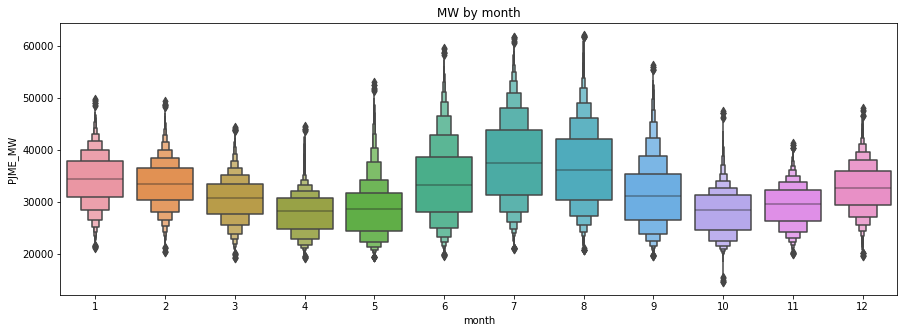

In [15]:
#monthly
show_distribution('month')

In [16]:
model = xgbreg(n_estimators=1000, 
                learning_rate=0.01,
                max_depth = 5,
                objective = "reg:squarederror",
                early_stopping_rounds = 50 
                )

In [17]:
FEATURES = ['hour', 'dayofweek', 'month', 'year', 'dayofyear']
TARGET = ['PJME_MW']
train = create_features(train_data)
test = create_features(test_data)

In [18]:
X_train = train[FEATURES]
X_test = test[FEATURES]
y_train = train[TARGET]
y_test = test[TARGET]

In [19]:
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True
        )

[0]	validation_0-rmse:32592.98450	validation_1-rmse:31567.31167
[1]	validation_0-rmse:32271.51641	validation_1-rmse:31243.03304
[2]	validation_0-rmse:31953.30607	validation_1-rmse:30922.05537
[3]	validation_0-rmse:31638.32950	validation_1-rmse:30604.34201
[4]	validation_0-rmse:31326.53595	validation_1-rmse:30289.88388
[5]	validation_0-rmse:31017.90552	validation_1-rmse:29978.62569
[6]	validation_0-rmse:30712.40475	validation_1-rmse:29670.51901
[7]	validation_0-rmse:30409.99018	validation_1-rmse:29366.34509
[8]	validation_0-rmse:30110.65739	validation_1-rmse:29064.50910
[9]	validation_0-rmse:29814.34798	validation_1-rmse:28766.52655
[10]	validation_0-rmse:29521.04729	validation_1-rmse:28471.57765
[11]	validation_0-rmse:29230.71385	validation_1-rmse:28179.69896
[12]	validation_0-rmse:28943.33766	validation_1-rmse:27890.05894
[13]	validation_0-rmse:28658.94156	validation_1-rmse:27604.56731
[14]	validation_0-rmse:28377.38027	validation_1-rmse:27321.10770
[15]	validation_0-rmse:28098.65311	

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [20]:
features_importance = pd.DataFrame(model.feature_importances_, index=model.feature_names_in_, columns=['importance'])

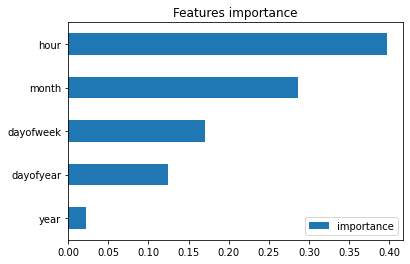

In [21]:
features_importance.sort_values('importance').plot(kind='barh', title='Features importance')
plt.show()

In [22]:
test_data['predictions'] = model.predict(X_test)

In [23]:
test_data.head()

,PJME_MW,hour,dayofweek,month,year,dayofyear,predictions
Datetime,,,,,,,
2015-12-31 01:00:00,24305.0,1,3,12,2015,365,27907.074219
2015-12-31 02:00:00,23156.0,2,3,12,2015,365,26940.429688
2015-12-31 03:00:00,22514.0,3,3,12,2015,365,26758.417969
2015-12-31 04:00:00,22330.0,4,3,12,2015,365,26758.417969
2015-12-31 05:00:00,22773.0,5,3,12,2015,365,26758.417969


In [24]:
df = df.merge(test_data[['predictions']], how='left', left_index=True, right_index=True)

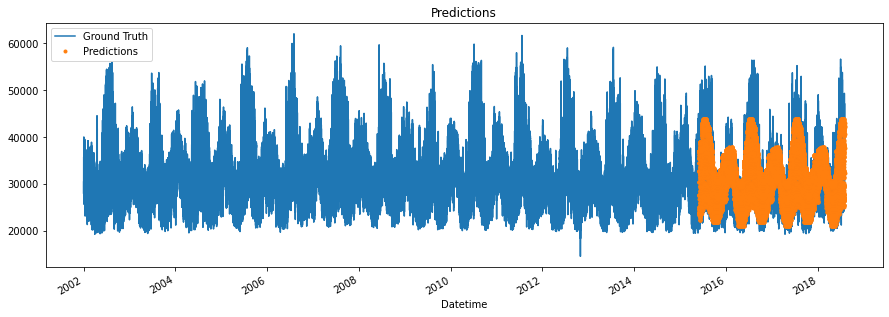

In [25]:
ax = df[['PJME_MW']].plot(figsize =(15,5))
df['predictions'].plot(ax=ax, style='.')
plt.legend(['Ground Truth', 'Predictions'])
ax.set_title('Predictions')
plt.show()

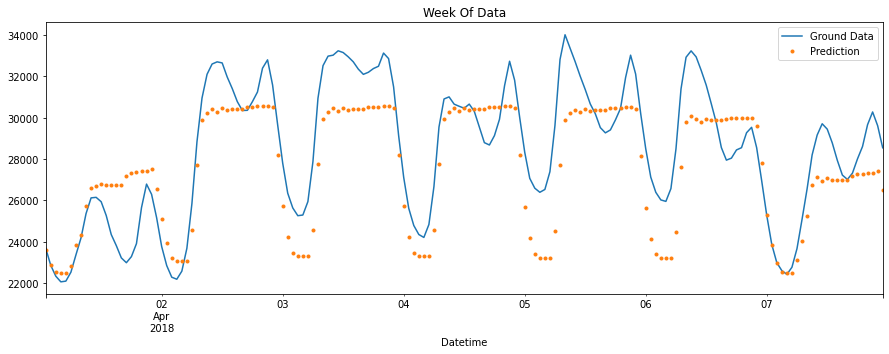

In [26]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['predictions'] \
    .plot(style='.')
plt.legend(['Ground Data','Prediction'])
plt.show()

In [27]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['predictions']))
score

3690.1167709127258